In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import matplotlib.pyplot as plt
import os

In [2]:
seed = 161
# random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
# os.environ['PYTHONHASHSEED'] = str(seed)

In [3]:
env = gym.make('CartPole-v0')
env.seed(seed);

In [4]:
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [5]:
def discretize(c_pos_val, c_vel_val, p_ang_val, p_vel_val, c_pos_s, c_vel_s, p_ang_s, p_vel_s):
    c_pos_indx = np.where(c_pos_s >= c_pos_val)[0][0].astype(int)
    c_vel_indx = np.where(c_vel_s >= c_vel_val)[0][0].astype(int)
    p_ang_indx = np.where(p_ang_s >= p_ang_val)[0][0].astype(int)
    p_vel_indx = np.where(p_vel_s >= p_vel_val)[0][0].astype(int)
    return [c_pos_indx, c_vel_indx, p_ang_indx, p_vel_indx]

In [6]:
QUANTIZATION_LEVEL = 18

In [7]:
Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL, 
                    N_ACTIONS))

In [8]:
c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)

In [9]:
T_LR           = 1e-1
T_GAMMA        = 0.9
T_EPSILON      = 0.9

NO_OF_NODES    = 100
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

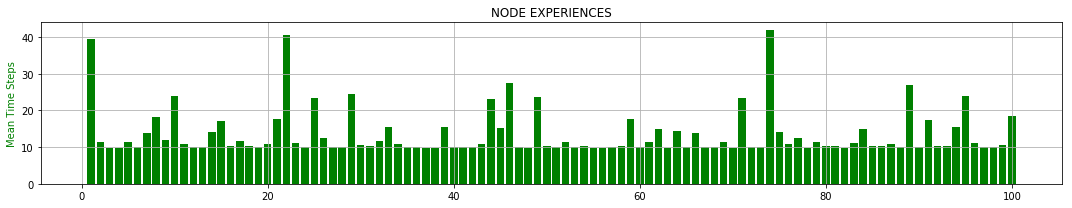

In [10]:
# Simulating a scenario where we have NO_OF_NODES number of nodes with zero initialized Q-TABLES
# All these nodes run for NO_OF_EPISODES and update their Q-TABLES
# Each episode has a time limit of TIMESTEP_LIMIT
mean_time_per_node = []

for i_node in range(NO_OF_NODES):
    Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL,
                    QUANTIZATION_LEVEL, 
                    N_ACTIONS))
    time_rec = []
    exp_rec = np.empty(N_STATES * 2 + 2)
    
    for i_episode in range(NO_OF_EPISODES):
        time_steps = 0
        s = env.reset()
        while True:
    #         env.render()
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > T_EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)
            
            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1
            
            experience = np.hstack((s,a,r,s_))
            exp_rec = np.vstack((exp_rec, experience))

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

            # learn
            this_state = tuple([c_pos_state, 
                          c_vel_state, 
                          p_ang_state, 
                          p_vel_state])

            next_state = tuple([ next_c_pos_state, 
                           next_c_vel_state, 
                           next_p_ang_state, 
                           next_p_vel_state])

            Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + T_LR * (r + T_GAMMA * Q_TABLE[next_state].max() - 
                                                                     Q_TABLE[this_state][a])
            if done:
                time_rec = np.append(time_rec, time_steps)
                break
            s = s_
    exp_rec = np.delete(exp_rec, 0, 0)
    EXP_FILE = './experiences/'+'XP_node_'+str(i_node)
    np.save(EXP_FILE, exp_rec)
    mean_time_per_node = np.append(mean_time_per_node, time_rec.mean())
    
#PLOT EXPERIENCES
fig = plt.figure(figsize = (15,3))
ax2 = fig.add_subplot(1, 1, 1)
data = mean_time_per_node
ax2.set_title("NODE EXPERIENCES")
ax2.bar(np.arange(1,data.shape[0]+1),data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Mean Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [11]:
# Hyper Parameters
BATCH_SIZE          = 32
LR                  = 1e-3  # learning rate
EPSILON             = 0.9   # greedy policy
GAMMA               = 0.9   # reward discount
TARGET_REPLACE_ITER = 100   # target update frequency
MEMORY_CAPACITY     = 2000
SEGREGATION_BIAS    = 6     # no. of non-terminal memories in batch

In [12]:
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [13]:
class Net(nn.Module):
    def __init__(self, ):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(N_STATES, 50)
        nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
        self.out = nn.Linear(50, N_ACTIONS)
        nn.init.xavier_uniform_(self.out.weight)   # initialization

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        actions_value = self.out(x)
        return actions_value

In [14]:
class DQN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
#         print("Neural net")
#         print(self.eval_net)

        self.learn_step_counter  = 0 # for target updating
        
        self.good_memory_counter = 0 # for storing non-terminal memories
        self.good_memory         = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.bad_memory_counter  = 0 # for storing terminal memories
        self.bad_memory          = np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action

    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy()
        return actions_value
    
#     def store_transition(self, s, a, r, s_):
#         transition = np.hstack((s, [a, r], s_))
#         if r > 0: #non-terminal rewards
#             # replace the old memory with new memory
#             index = self.good_memory_counter % int(MEMORY_CAPACITY/2)
#             self.good_memory[index, :] = transition
#             self.good_memory_counter += 1
        
#         else: #terminal rewards
#             # replace the old memory with new memory
#             index = self.bad_memory_counter % int(MEMORY_CAPACITY/2)
#             self.bad_memory[index, :] = transition
#             self.bad_memory_counter += 1

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1

        # sample batch transitions
        good_sample_index = np.random.choice(int(self.good_memory.shape[0]), int(SEGREGATION_BIAS))
        bad_sample_index  = np.random.choice(int(self.bad_memory.shape[0]), int(BATCH_SIZE-SEGREGATION_BIAS))

        b_good_memory = self.good_memory[good_sample_index, :]
        b_bad_memory  = self.bad_memory[bad_sample_index, :]
        b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [15]:
dqn = DQN()

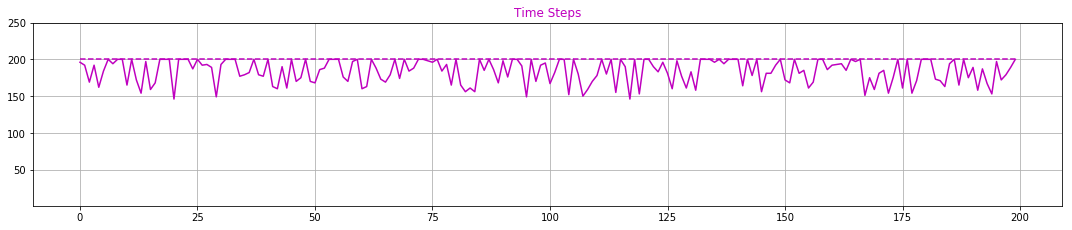

In [16]:
#GATHER ALL EXPERIENCES
all_exp = np.empty(N_STATES*2 + 2)

directory_in_str = "./experiences/"
directory = os.fsencode(directory_in_str)
filelist = []
no_of_exp = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):
        buffer = np.load(directory_in_str + filename)
        no_of_exp += buffer.shape[0]
        all_exp = np.vstack((all_exp, buffer))
all_exp = np.delete(all_exp, 0, 0)

#shuffle experiences
np.random.shuffle(all_exp)

#segregate experiences
dqn.good_memory = all_exp[all_exp[:,5] == 1]
dqn.bad_memory = all_exp[all_exp[:,5] < 1]

#learn
NN_ITERATIONS = 20000
for _ in range(NN_ITERATIONS):
    dqn.learn()
    
#test NN policy
time_rec = []
for i_episode in range(200):
    time_step = 0
    s = env.reset()
    while True:
#         env.render()
        time_step += 1 
        a = dqn.choose_greedy_action(s)
        s_, r, done, info = env.step(a)
        if done:
            break
        s = s_
    time_rec = np.append(time_rec, time_step)

#check NN performance
fig = plt.figure(figsize = (15,6))
ax2 = fig.add_subplot(2, 1, 1)
data = time_rec
ax2.plot(data, color = 'm')
ax2.plot(np.ones_like(data)*200, 'm--')
ax2.set_title('Time Steps',color = 'm')
ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [17]:
# Discretize the Q-Value Functions
NEW_Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL, 
                N_ACTIONS))

c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)


for c_pos_indx in np.arange(0,c_pos_s.size):
    for c_vel_indx in np.arange(0,c_vel_s.size):
        for p_ang_indx in np.arange(0,p_ang_s.size):
            for p_vel_indx in np.arange(0,p_vel_s.size):

                    state = [c_pos_s[c_pos_indx],
                             c_vel_s[c_vel_indx],
                             p_ang_s[p_ang_indx],
                             p_vel_s[p_vel_indx]]

                    NEW_Q_TABLE[c_pos_indx,
                            c_vel_indx,
                            p_ang_indx,
                            p_vel_indx, :] = dqn.get_qvals(state)
    
FILENAME = 'NEW_Q_TABLE_'+str(QUANTIZATION_LEVEL)
np.save(FILENAME, NEW_Q_TABLE)

In [19]:
print("SECOND ITERATION")

SECOND ITERATION


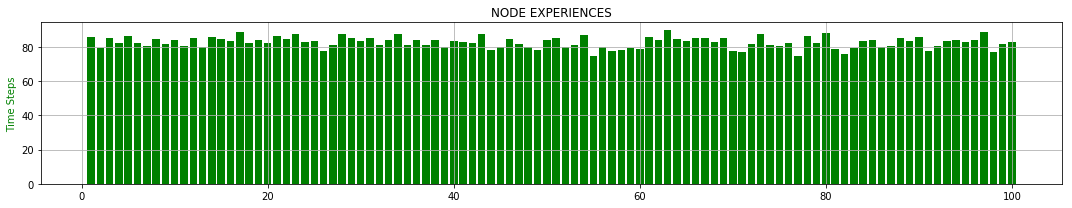

In [20]:
#Updating the nodes with the discretized Q_TABLE
#Checking performance with learning
#Saving new experiences
mean_time_per_node = []

for i_node in range(NO_OF_NODES):
    Q_TABLE = np.load(FILENAME+'.npy')
    time_rec = []
    exp_rec = np.empty(N_STATES * 2 + 2)
    
    for i_episode in range(NO_OF_EPISODES):
        time_steps = 0
        s = env.reset()
        while True:
    #         env.render()
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)
            
            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1
            
            experience = np.hstack((s,a,r,s_))
            exp_rec = np.vstack((exp_rec, experience))

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

            # learn
            this_state = tuple([c_pos_state, 
                          c_vel_state, 
                          p_ang_state, 
                          p_vel_state])

            next_state = tuple([ next_c_pos_state, 
                           next_c_vel_state, 
                           next_p_ang_state, 
                           next_p_vel_state])

            Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + LR * (r + GAMMA * Q_TABLE[next_state].max() - 
                                                                     Q_TABLE[this_state][a])
            if done:
                time_rec = np.append(time_rec, time_steps)
                break
            s = s_
    exp_rec = np.delete(exp_rec, 0, 0)
    EXP_FILE = './experiences/'+'XP_node_'+str(i_node)
    np.save(EXP_FILE, exp_rec)
    mean_time_per_node = np.append(mean_time_per_node, time_rec.mean())


#PLOT EXPERIENCES
fig = plt.figure(figsize = (15,3))

ax2 = fig.add_subplot(1, 1, 1)
data = mean_time_per_node
ax2.set_title("NODE EXPERIENCES")
ax2.bar(np.arange(1,data.shape[0]+1),data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

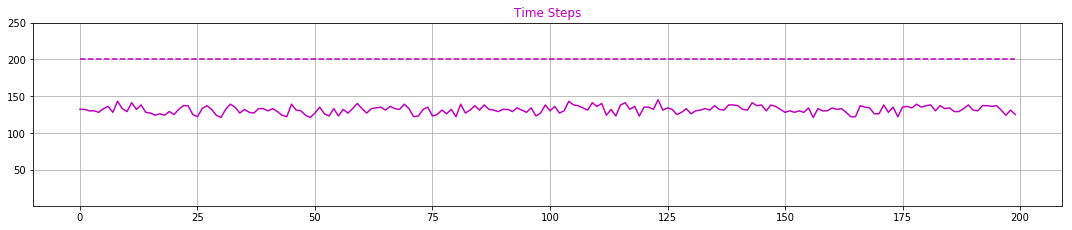

In [21]:
#GATHER ALL EXPERIENCES
all_exp = np.empty(N_STATES*2 + 2)

directory_in_str = "./experiences/"
directory = os.fsencode(directory_in_str)
filelist = []
no_of_exp = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):
        buffer = np.load(directory_in_str + filename)
        no_of_exp += buffer.shape[0]
        all_exp = np.vstack((all_exp, buffer))
all_exp = np.delete(all_exp, 0, 0)

#shuffle experiences
np.random.shuffle(all_exp)

#segregate experiences
dqn.good_memory = all_exp[all_exp[:,5] == 1]
dqn.bad_memory = all_exp[all_exp[:,5] < 1]

#learn
NN_ITERATIONS = 20000
for _ in range(NN_ITERATIONS):
    dqn.learn()
    
    
#test NN policy
env = gym.make('CartPole-v0')
time_rec = []
for i_episode in range(200):
    time_step = 0
    s = env.reset()
    while True:
#         env.render()
        time_step += 1 
        a = dqn.choose_greedy_action(s)
        s_, r, done, info = env.step(a)
        if done:
            break
        s = s_
    time_rec = np.append(time_rec, time_step)
env.close()

fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = time_rec
ax2.plot(data, color = 'm')
ax2.plot(np.ones_like(data)*200, 'm--')
ax2.set_title('Time Steps',color = 'm')
ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [22]:
# Discretize the Q-Value Functions
NEW_Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL, 
                N_ACTIONS))

c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)


for c_pos_indx in np.arange(0,c_pos_s.size):
    for c_vel_indx in np.arange(0,c_vel_s.size):
        for p_ang_indx in np.arange(0,p_ang_s.size):
            for p_vel_indx in np.arange(0,p_vel_s.size):

                    state = [c_pos_s[c_pos_indx],
                             c_vel_s[c_vel_indx],
                             p_ang_s[p_ang_indx],
                             p_vel_s[p_vel_indx]]

                    NEW_Q_TABLE[c_pos_indx,
                            c_vel_indx,
                            p_ang_indx,
                            p_vel_indx, :] = dqn.get_qvals(state)
    
FILENAME = 'NEW_Q_TABLE_'+str(QUANTIZATION_LEVEL)
np.save(FILENAME, NEW_Q_TABLE)

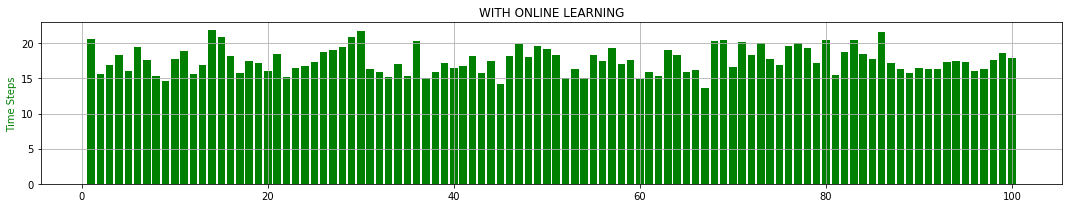

In [23]:
#Updating the nodes with the discretized Q_TABLE
#Checking performance without learning
mean_time_per_node = []

for i_node in range(NO_OF_NODES):
    Q_TABLE = np.load(FILENAME+'.npy')
    time_rec = []
    
    for i_episode in range(NO_OF_EPISODES):
        time_steps = 0
        s = env.reset()
        while True:
    #         env.render()
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)
            
            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

            # learn
            this_state = tuple([c_pos_state, 
                          c_vel_state, 
                          p_ang_state, 
                          p_vel_state])

            next_state = tuple([ next_c_pos_state, 
                           next_c_vel_state, 
                           next_p_ang_state, 
                           next_p_vel_state])

#             Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + LR * (r + GAMMA * Q_TABLE[next_state].max() - 
#                                                                      Q_TABLE[this_state][a])
            if done:
                time_rec = np.append(time_rec, time_steps)
                break
            s = s_
    mean_time_per_node = np.append(mean_time_per_node, time_rec.mean())

fig = plt.figure(figsize = (15,3))

ax2 = fig.add_subplot(1, 1, 1)
data = mean_time_per_node
ax2.set_title("WITH ONLINE LEARNING")
ax2.bar(np.arange(1,data.shape[0]+1),data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

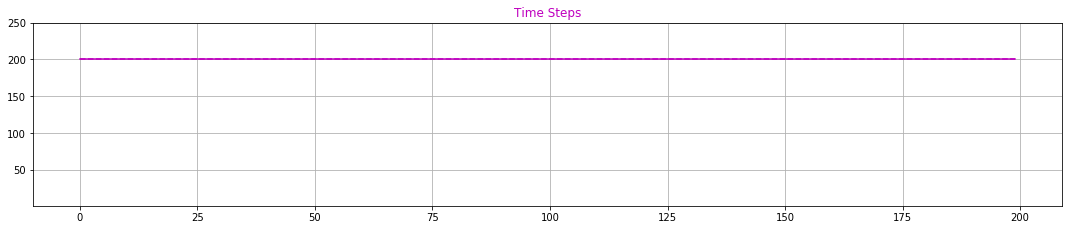

In [24]:
#GATHER ALL EXPERIENCES
all_exp = np.empty(N_STATES*2 + 2)

directory_in_str = "./experiences/"
directory = os.fsencode(directory_in_str)
filelist = []
no_of_exp = 0
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".npy"):
        buffer = np.load(directory_in_str + filename)
        no_of_exp += buffer.shape[0]
        all_exp = np.vstack((all_exp, buffer))
all_exp = np.delete(all_exp, 0, 0)

#shuffle experiences
np.random.shuffle(all_exp)

#segregate experiences
dqn.good_memory = all_exp[all_exp[:,5] == 1]
dqn.bad_memory = all_exp[all_exp[:,5] < 1]

#learn
NN_ITERATIONS = 20000
for _ in range(NN_ITERATIONS):
    dqn.learn()
    
    
#test NN policy
time_rec = []
for i_episode in range(200):
    time_step = 0
    s = env.reset()
    while True:
#         env.render()
        time_step += 1 
        a = dqn.choose_greedy_action(s)
        s_, r, done, info = env.step(a)
        if done:
            break
        s = s_
    time_rec = np.append(time_rec, time_step)
env.close()

fig = plt.figure(figsize = (15,6))

ax2 = fig.add_subplot(2, 1, 1)
data = time_rec
ax2.plot(data, color = 'm')
ax2.plot(np.ones_like(data)*200, 'm--')
ax2.set_title('Time Steps',color = 'm')
ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [26]:
# Discretize the Q-Value Functions
NEW_Q_TABLE = np.zeros((QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL,
                QUANTIZATION_LEVEL, 
                N_ACTIONS))

c_pos_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
c_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)
p_ang_s = np.linspace(-1, 1, QUANTIZATION_LEVEL)
p_vel_s = np.linspace(-5, 5, QUANTIZATION_LEVEL)


for c_pos_indx in np.arange(0,c_pos_s.size):
    for c_vel_indx in np.arange(0,c_vel_s.size):
        for p_ang_indx in np.arange(0,p_ang_s.size):
            for p_vel_indx in np.arange(0,p_vel_s.size):

                    state = [c_pos_s[c_pos_indx],
                             c_vel_s[c_vel_indx],
                             p_ang_s[p_ang_indx],
                             p_vel_s[p_vel_indx]]

                    NEW_Q_TABLE[c_pos_indx,
                            c_vel_indx,
                            p_ang_indx,
                            p_vel_indx, :] = dqn.get_qvals(state)
    
FILENAME = 'NEW_Q_TABLE_'+str(QUANTIZATION_LEVEL)
np.save(FILENAME, NEW_Q_TABLE)

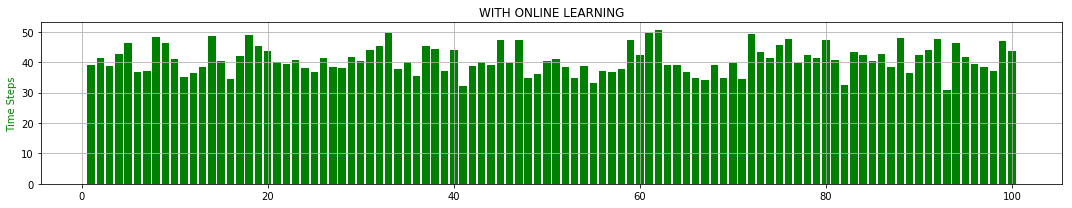

In [27]:
#Updating the nodes with the discretized Q_TABLE
#Checking performance without learning
mean_time_per_node = []

for i_node in range(NO_OF_NODES):
    Q_TABLE = np.load(FILENAME+'.npy')
    time_rec = []
    
    for i_episode in range(NO_OF_EPISODES):
        time_steps = 0
        s = env.reset()
        while True:
    #         env.render()
            [c_pos_state, 
            c_vel_state, 
            p_ang_state, 
            p_vel_state] = discretize(s[0],s[1],s[2],s[3],
                                     c_pos_s, 
                                     c_vel_s, 
                                     p_ang_s, 
                                     p_vel_s)
            time_steps += 1
            if np.random.uniform() > EPSILON:   # greedy
                a = np.random.randint(0, N_ACTIONS)
            else:
                a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

             # take action
            s_, r, done, info = env.step(a)
            
            if done:
                r = -1
                if time_steps >= TIMESTEP_LIMIT:
                    r = 1

            #discretize next_state
            [next_c_pos_state, 
            next_c_vel_state, 
            next_p_ang_state, 
            next_p_vel_state] = discretize(s_[0],    s_[1],    s_[2],    s_[3],
                                          c_pos_s,  c_vel_s,  p_ang_s,  p_vel_s)

            # learn
            this_state = tuple([c_pos_state, 
                          c_vel_state, 
                          p_ang_state, 
                          p_vel_state])

            next_state = tuple([ next_c_pos_state, 
                           next_c_vel_state, 
                           next_p_ang_state, 
                           next_p_vel_state])

#             Q_TABLE[this_state][a] = Q_TABLE[this_state][a] + LR * (r + GAMMA * Q_TABLE[next_state].max() - 
#                                                                      Q_TABLE[this_state][a])
            if done:
                time_rec = np.append(time_rec, time_steps)
                break
            s = s_
    mean_time_per_node = np.append(mean_time_per_node, time_rec.mean())

fig = plt.figure(figsize = (15,3))

ax2 = fig.add_subplot(1, 1, 1)
data = mean_time_per_node
ax2.set_title("WITH ONLINE LEARNING")
ax2.bar(np.arange(1,data.shape[0]+1),data, color = 'g')
# ax2.plot(np.ones_like(data)*200, 'g--')

ax2.set_ylabel('Time Steps',color = 'g')
# ax2.set_ylim([1,2.5e2])
fig.tight_layout()
ax2.grid()
plt.show()

In [25]:
# #TESTING
# time_rec = []
# # S_FILENAME = 'cartpole_limited'
# # M_FILENAME = S_FILENAME +'_Q_TABLE_'+str(QUANTIZATION_LEVEL)+'.npy'
# # Q_TABLE = np.load(M_FILENAME)


# for i_episode in range(NO_OF_EPISODES):

#     time_steps = 0
#     s = env.reset()
#     while True:
# #         env.render()

#         [c_pos_state, 
#         c_vel_state, 
#         p_ang_state, 
#         p_vel_state] = discretize(s[0],    s[1],    s[2],    s[3],
#                                  c_pos_s, c_vel_s, p_ang_s, p_vel_s)

#         time_steps += 1
#         a = Q_TABLE[c_pos_state, c_vel_state, p_ang_state, p_vel_state, :].argmax()

#         # take action
#         s_, r, done, info = env.step(a)
        
        

#         if done:
#             time_rec = np.append(time_rec, time_steps)

#             break
#         s = s_
# env.close()
# fig = plt.figure(figsize = (15,3))

# ax2 = fig.add_subplot(1, 1, 1)
# data = time_rec
# ax2.set_title("QUANTIZATION: "+str(QUANTIZATION_LEVEL))
# ax2.plot(data, color = 'g')
# # ax2.plot(np.ones_like(data)*200, 'g--')

# ax2.set_ylabel('Time Steps',color = 'g')
# # ax2.set_ylim([1,2.5e2])
# fig.tight_layout()
# ax2.grid()
# plt.show()